In [1]:
!pip install pinecone-client openai sentence-transformers tiktoken datasets

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 16.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.7 MB/s eta 0:00:00


In [1]:
from openai import OpenAI  #used to interact with OpenAI's APIs
from datetime import datetime #allows work with date and times
import hashlib #import hashlib module for using hash function
import re  # module for regular expression operations, useful for text processing and data cleaning
import os  # provides a way of using operating system dependent functionality like reading or writing to files
from sentence_transformers import CrossEncoder #class "CrossEncode" is used for sentence-level embedding generation


from tqdm import tqdm #library that provides progress bars for loops 
import numpy as np #for scientific computing
from torch import nn #nn module for using neural network layers and functions

import logging #for logging message
from pinecone import Pinecone, ServerlessSpec #setting up serverless database or search infrastructure

logger = logging.getLogger() #retrieves logger instance
logger.setLevel(logging.CRITICAL) #log level to CRITICAL, meaning only critical errors will be logged


/Users/joeunyook/Library/Python/3.11/lib/python/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Users/joeunyook/Library/Python/3.11/lib/python/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
pinecone_key = os.environ.get('PINECONE_API_KEY')
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

INDEX_NAME = 'semantic-search-test'
NAMESPACE = 'default'
ENGINE = 'text-embedding-3-large'  # has vector size 3072

pc = Pinecone(
    api_key=pinecone_key
) 

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [ ]:
# helper functions to get lists of embeddings from the OpenAI API
def get_embeddings(texts, engine=ENGINE): # texts : list of text
    response = client.embeddings.create(  #the function returns a response containing embeddings for the text
        input=texts,
        model=engine
    )

    return [d.embedding for d in list(response.data)] #response.data is where actual embedding data is; list() used to convert special embedding data type to python list
#d.embedding extracts the embedding field from each object d
# as a whole, it creates a standardized list of embeddings only, discarding additional metadata

def get_embedding(text, engine=ENGINE):
    return get_embeddings([text], engine)[0]  #take a LIST of text as an input; [text]: text considered as string input; [0]: take first element only
'''
get_embeddings is for multiple texts and get_embedding is for single text
'''
len(get_embedding('hi')), len(get_embeddings(['hi', 'hello']))

(3072, 2)

In [ ]:
if INDEX_NAME not in pc.list_indexes().names(): #INDEX_NAME is a new structure(storage) in Pinecone database; here, it stores all the OpenAI embedding
    print(f'Creating index {INDEX_NAME}')
    pc.create_index(
        name=INDEX_NAME,  # The name of the index
        dimension=3072,  # The dimensionality of the vectors for our OpenAI embedder
        metric='cosine',  # The similarity metric to use when searching the index
        spec=ServerlessSpec(  # specifications for how the index will be deployed and hosted on Pinecone's infrastructure
            cloud='aws',
            region='us-west-2'
        )
    )

# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

Creating index semantic-search-test


In [ ]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [ ]:
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [ ]:
def prepare_for_pinecone(texts, engine=ENGINE):
    # Get the current UTC date and time
    now = datetime.utcnow()

    # Generate vector embeddings for each string in the input list, using the specified engine
    embeddings = get_embeddings(texts, engine=engine)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding vector embedding
    # The my_hash() function is used to generate a unique hash for each string, and the datetime.utcnow() function is used to generate the current UTC date and time
    return [
        (
            my_hash(text),  # A unique ID for each string, generated using the my_hash() function
            embedding,  # The vector embedding of the string
            dict(text=text, date_uploaded=now)  # A dictionary of metadata, including the original text and the current UTC date and time
        )
        for text, embedding in zip(texts, embeddings)  # Iterate over each input string and its corresponding vector embedding
    ]


In [ ]:
texts = ['hi']

In [ ]:
_id, embedding, metadata = prepare_for_pinecone(texts)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x781359d856c0>, 'json_data': {'input': ['hi'], 'model': 'text-embedding-3-large', 'encoding_format': 'base64'}}
DEBUG:httpcore.connection:close.started
DEBUG:httpcore.connection:close.complete
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=5.0 socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x781359da9c00>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x781425c1b540> server_hostname='api.openai.com' timeout=5.0
DEBUG:httpcore.connection:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x781359dab940>
DEBUG:httpcore.http11:send_request_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_headers.complete
D

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  3072 
META: {'text': 'hi', 'date_uploaded': datetime.datetime(2024, 2, 4, 15, 4, 25, 558722)}


In [ ]:
def upload_texts_to_pinecone(texts, namespace=NAMESPACE, batch_size=None, show_progress_bar=False):
    # Call the prepare_for_pinecone function to prepare the input texts for indexing
    total_upserted = 0
    if not batch_size:
        batch_size = len(texts)

    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        batch = texts[i: i + batch_size]
        prepared_texts = prepare_for_pinecone(batch)

        # Use the upsert() method of the index object to upload the prepared texts to Pinecone
        total_upserted += index.upsert(
            vectors=prepared_texts,
            namespace=namespace
        )['upserted_count']


    return total_upserted

# Call the upload_texts_to_pinecone() function with the input texts
upload_texts_to_pinecone(texts)


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x781359c4c550>, 'json_data': {'input': ['hi'], 'model': 'text-embedding-3-large', 'encoding_format': 'base64'}}
DEBUG:httpcore.http11:send_request_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_headers.complete
DEBUG:httpcore.http11:send_request_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_body.complete
DEBUG:httpcore.http11:receive_response_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Sun, 04 Feb 2024 15:04:26 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'access-control-allow-origin', b'*'), (b'openai-model', b'text-embedding-3-large'), (b'openai-organization', b'user-9vr5p5naslsmcksivdee

1

In [ ]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [ ]:
texts

['hi']

In [ ]:
def query_from_pinecone(query, top_k=3, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

In [ ]:
import hashlib

def delete_texts_from_pinecone(texts, namespace=NAMESPACE):
    # Compute the hash (id) for each text
    hashes = [hashlib.md5(text.encode()).hexdigest() for text in texts]

    # The ids parameter is used to specify the list of IDs (hashes) to delete
    return index.delete(ids=hashes, namespace=namespace)

# delete our text
delete_texts_from_pinecone(texts)

# test that the index is empty
query_from_pinecone('hello')

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x781359c4d3f0>, 'json_data': {'input': ['hello'], 'model': 'text-embedding-3-large', 'encoding_format': 'base64'}}
DEBUG:httpcore.http11:send_request_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_headers.complete
DEBUG:httpcore.http11:send_request_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_body.complete
DEBUG:httpcore.http11:receive_response_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Sun, 04 Feb 2024 15:04:28 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'access-control-allow-origin', b'*'), (b'openai-model', b'text-embedding-3-large'), (b'openai-organization', b'user-9vr5p5naslsmcksiv

[]

In [ ]:
# Importing the tiktoken library
import tiktoken

# Initializing a tokenizer for the 'cl100k_base' model
# This tokenizer is designed to work with the 'ada-002' embedding model
tokenizer = tiktoken.get_encoding("cl100k_base")

# Using the tokenizer to encode the text 'hey there'
# The resulting output is a list of integers representing the encoded text
# This is the input format required for embedding using the 'ada-002' model
tokenizer.encode('hey there')


[36661, 1070]

In [ ]:
# Function to split the text into chunks of a maximum number of tokens. Inspired by OpenAI
def overlapping_chunks(text, max_tokens = 500, overlapping_factor = 5):
    '''
    max_tokens: tokens we want per chunk
    overlapping_factor: number of sentences to start each chunk with that overlaps with the previous chunk
    '''

    # Split the text using punctuation
    sentences = re.split(r'[.?!]', text)

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks, tokens_so_far, chunk = [], 0, []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            if overlapping_factor > 0:
                chunk = chunk[-overlapping_factor:]
                tokens_so_far = sum([len(tokenizer.encode(c)) for c in chunk])
            else:
                chunk = []
                tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks

In [ ]:
query = 'How do z scores work?'

results_from_pinecone = query_from_pinecone(query, top_k=5)

for result_from_pinecone in results_from_pinecone:
    print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{result_from_pinecone['metadata']['text'][:50]}")


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x7813597c16c0>, 'json_data': {'input': ['How do z scores work?'], 'model': 'text-embedding-3-large', 'encoding_format': 'base64'}}
DEBUG:httpcore.http11:send_request_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_headers.complete
DEBUG:httpcore.http11:send_request_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_body.complete
DEBUG:httpcore.http11:receive_response_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Sun, 04 Feb 2024 15:04:32 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'access-control-allow-origin', b'*'), (b'openai-model', b'text-embedding-3-large'), (b'openai-organization', b'user-9

In [ ]:
"""
This example computes the score between a query and all possible
sentences in a corpus using a Cross-Encoder for semantic textual similarity (STS).
It output then the most similar sentences for the given query.
"""
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np
from torch import nn

# Pre-trained cross encoder


In [ ]:
# remove debug and info logs
import logging
logging.basicConfig(level=logging.WARNING)

In [ ]:
from copy import copy

def get_results_from_pinecone(query, top_k=3, re_rank_model=None, verbose=True, correct_hash=None):

    results_from_pinecone = query_from_pinecone(query, top_k=top_k)

    if not results_from_pinecone:
        return []

    if verbose:
        print("Query:", query)


    final_results = []

    retrieved_correct_position, reranked_correct_position = None, None
    for idx, result_from_pinecone in enumerate(results_from_pinecone):
        if correct_hash and result_from_pinecone['id'] == correct_hash:
            retrieved_correct_position = idx

    if re_rank_model is not None:
        if verbose:
            print('Document ID (Hash)\t\tRetrieval Score\tCE Score\tText')

        sentence_combinations = [[query, result_from_pinecone['metadata']['text']] for result_from_pinecone in results_from_pinecone]

        # Compute the similarity scores for these combinations
        similarity_scores = re_rank_model.predict(sentence_combinations, activation_fct=nn.Sigmoid())

        # Sort the scores in decreasing order
        sim_scores_argsort = list(reversed(np.argsort(similarity_scores)))
        sim_scores_sort = list(reversed(np.sort(similarity_scores)))
        top_re_rank_score = sim_scores_sort[0]

        # Print the scores
        # print(list(zip(sim_scores_argsort, sim_scores_sort)))
        for idx in sim_scores_argsort:
            result_from_pinecone = results_from_pinecone[idx]
            if correct_hash and result_from_pinecone['id'] == correct_hash:
                reranked_correct_position = idx
            final_results.append({'score': similarity_scores[idx], 'id': result_from_pinecone['id'], 'metadata': result_from_pinecone['metadata']})
            if verbose:
                print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{similarity_scores[idx]:.6f}\t{result_from_pinecone['metadata']['text'][:50]}")
        return {'final_results': final_results, 'retrieved_correct_position': retrieved_correct_position, 'reranked_correct_position': reranked_correct_position, 'results_from_pinecone': results_from_pinecone, 'top_re_rank_score': top_re_rank_score}
        # return

    if verbose:
        print('Document ID (Hash)\t\tRetrieval Score\tText')
    for result_from_pinecone in results_from_pinecone:
        final_results.append(result_from_pinecone)
        if verbose:
            print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{result_from_pinecone['metadata']['text'][:50]}")

    return {'final_results': final_results, 'retrieved_correct_position': retrieved_correct_position, 'reranked_correct_position': reranked_correct_position}

In [ ]:
index.describe_index_stats()  # no vectors inside

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'default': {'vector_count': 2311}},
 'total_vector_count': 2311}

In [ ]:
from datasets import load_dataset

dataset = load_dataset("xtreme", "MLQA.en.en")

# rename test -> train and val -> test (as we will use it in later in this chapter)
dataset['train'] = dataset['test']
dataset['test'] = dataset['validation']
del dataset['validation']

dataset

DatasetDict({
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1148
    })
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11590
    })
})

In [ ]:
dataset['train'][0], dataset['train'][1]

({'id': 'a4968ca8a18de16aa3859be760e43dbd3af3fce9',
  'title': 'Area 51',
  'context': 'In 1994, five unnamed civilian contractors and the widows of contractors Walter Kasza and Robert Frost sued the USAF and the United States Environmental Protection Agency. Their suit, in which they were represented by George Washington University law professor Jonathan Turley, alleged they had been present when large quantities of unknown chemicals had been burned in open pits and trenches at Groom. Biopsies taken from the complainants were analyzed by Rutgers University biochemists, who found high levels of dioxin, dibenzofuran, and trichloroethylene in their body fat. The complainants alleged they had sustained skin, liver, and respiratory injuries due to their work at Groom, and that this had contributed to the deaths of Frost and Kasza. The suit sought compensation for the injuries they had sustained, claiming the USAF had illegally handled toxic materials, and that the EPA had failed in its dut

In [ ]:
unique_passages = list(set(dataset['test']['context']))
for idx in tqdm(range(0, len(unique_passages), 32)):
    passages = unique_passages[idx:idx + 32]
    upload_texts_to_pinecone(passages)


100%|██████████| 31/31 [01:28<00:00,  2.87s/it]


In [ ]:
len(unique_passages)

978

In [ ]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'default': {'vector_count': 978}},
 'total_vector_count': 978}

In [ ]:
# Pre-trained cross encoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', num_labels=1)

q_to_hash = {data['question']: my_hash(data['context']) for data in dataset['test']}

In [ ]:
import logging

# Set the logging level to ERROR to suppress DEBUG and INFO logs
logging.getLogger().setLevel(logging.ERROR)


In [ ]:
from copy import copy

def get_results_from_pinecone(query, top_k=3, re_rank_model=None, verbose=True, correct_hash=None):
    results_from_pinecone = query_from_pinecone(query, top_k=top_k)

    if verbose:
        print("Query:", query)

    reranked_results = []

    retrieved_correct_position, reranked_correct_position = None, None
    for idx, result_from_pinecone in enumerate(results_from_pinecone):
        if correct_hash and result_from_pinecone['id'] == correct_hash:
            retrieved_correct_position = idx

    if re_rank_model is not None:
        if verbose:
            print('Document ID (Hash)\t\tRetrieval Score\tCE Score\tText')

        sentence_combinations = [[query, result_from_pinecone['metadata']['text']] for result_from_pinecone in results_from_pinecone]

        # Compute the similarity scores for these combinations
        similarity_scores = re_rank_model.predict(sentence_combinations, activation_fct=nn.Sigmoid())

        # Sort the scores in decreasing order
        sim_scores_argsort = list(reversed(np.argsort(similarity_scores)))
        for rerank_idx, idx in enumerate(sim_scores_argsort):
            result_from_pinecone = results_from_pinecone[idx]
            if correct_hash and result_from_pinecone['id'] == correct_hash:
                reranked_correct_position = rerank_idx
            reranked_results.append({'score': similarity_scores[idx], 'id': result_from_pinecone['id'], 'metadata': result_from_pinecone['metadata']})
            if verbose:
                print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{similarity_scores[idx]:.6f}\t{result_from_pinecone['metadata']['text'][:50]}")
        return {'final_results': final_results, 'retrieved_correct_position': retrieved_correct_position, 'reranked_correct_position': reranked_correct_position, 'results_from_pinecone': results_from_pinecone}

    if verbose:
        print('Document ID (Hash)\t\tRetrieval Score\tText')
    for result_from_pinecone in results_from_pinecone:
        final_results.append(result_from_pinecone)
        if verbose:
            print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{result_from_pinecone['metadata']['text'][:50]}")

    return {'final_results': final_results, 'retrieved_correct_position': retrieved_correct_position, 'reranked_correct_position': reranked_correct_position}

In [ ]:
unique_inputs = list(set(dataset['test']['question']))
len(unique_inputs)

1148

In [ ]:
query = unique_inputs[0]
print(query)
r = get_results_from_pinecone(
    query, top_k=100, re_rank_model=cross_encoder, correct_hash=q_to_hash[query],
    verbose=False
    )

r['retrieved_correct_position'], r['reranked_correct_position']

What was Pope Caius role in the catholic church?


(0, 1)

In [ ]:
# super_glue_metric = load('super_glue', 'boolq')  # just accuracy

# Let's test the performance re-ranking against validation datapoints
# Note we could not use Pinecone here to speed things up
#  but it's also a good time to test latency of the pipeline with Pinecone
test_sample = dataset['test']

In [ ]:
TOP_K=50

In [ ]:
logger.setLevel(logging.CRITICAL)

predictions = []

for question in tqdm(test_sample['question']):
    r = get_results_from_pinecone(
        question, top_k=TOP_K, re_rank_model=cross_encoder, correct_hash=q_to_hash[question],
        verbose=False
        )

    r['retrieved_correct_position'], r['reranked_correct_position']
    predictions.append(r)
    if len(predictions) % 100 == 0:
        retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in predictions])/len(predictions)
        re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in predictions])/len(predictions)

        print(f'Accuracy without re-ranking: {retrieved_accuracy}')
        print(f'Accuracy with re-ranking: {re_ranked_accuracy}')


  9%|▊         | 100/1148 [02:39<27:57,  1.60s/it]

Accuracy without re-ranking: 0.78
Accuracy with re-ranking: 0.84


 17%|█▋        | 200/1148 [05:19<24:58,  1.58s/it]

Accuracy without re-ranking: 0.765
Accuracy with re-ranking: 0.835


 26%|██▌       | 300/1148 [07:59<22:08,  1.57s/it]

Accuracy without re-ranking: 0.7666666666666667
Accuracy with re-ranking: 0.8166666666666667


 35%|███▍      | 400/1148 [12:10<19:30,  1.56s/it]

Accuracy without re-ranking: 0.7625
Accuracy with re-ranking: 0.825


 44%|████▎     | 500/1148 [14:50<17:13,  1.59s/it]

Accuracy without re-ranking: 0.764
Accuracy with re-ranking: 0.834


 52%|█████▏    | 600/1148 [17:29<14:38,  1.60s/it]

Accuracy without re-ranking: 0.7683333333333333
Accuracy with re-ranking: 0.8466666666666667


 61%|██████    | 700/1148 [20:08<12:14,  1.64s/it]

Accuracy without re-ranking: 0.7471428571428571
Accuracy with re-ranking: 0.8285714285714286


 70%|██████▉   | 800/1148 [22:46<09:11,  1.58s/it]

Accuracy without re-ranking: 0.74875
Accuracy with re-ranking: 0.82125


 78%|███████▊  | 900/1148 [25:26<06:36,  1.60s/it]

Accuracy without re-ranking: 0.7388888888888889
Accuracy with re-ranking: 0.8188888888888889


 87%|████████▋ | 1000/1148 [28:05<04:05,  1.66s/it]

Accuracy without re-ranking: 0.741
Accuracy with re-ranking: 0.819


 96%|█████████▌| 1100/1148 [30:45<01:16,  1.60s/it]

Accuracy without re-ranking: 0.7509090909090909
Accuracy with re-ranking: 0.8272727272727273


100%|██████████| 1148/1148 [32:01<00:00,  1.67s/it]


In [ ]:
retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in predictions])/len(predictions)
re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in predictions])/len(predictions)

print(f'Accuracy without re-ranking: {retrieved_accuracy}')
print(f'Accuracy with re-ranking: {re_ranked_accuracy}')

Accuracy without re-ranking: 0.7543554006968641
Accuracy with re-ranking: 0.8327526132404182


In [ ]:
import pandas as pd

predictions_df = pd.DataFrame(predictions)
predictions_df.head()

,final_results,retrieved_correct_position,reranked_correct_position,results_from_pinecone
0,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '2f90090e21f19450887d5f3ff781e541', '..."
1,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '49201636ad4102735125e146c0dbafa4', '..."
2,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '80d92494d2b06f341842f1855d2938cf', '..."
3,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,2.0,"[{'id': 'e3fd54f33b021ea3cf88b438fefcada7', '..."
4,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '37ed40c20d4e1b9cc8d6cc27a4d0fff3', '..."


array([[<Axes: title={'center': 'retrieved_correct_position'}>,
        <Axes: title={'center': 'reranked_correct_position'}>]],
      dtype=object)

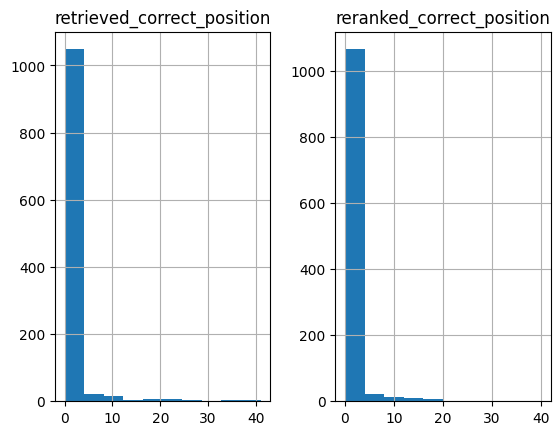

In [ ]:
predictions_df[['retrieved_correct_position', 'reranked_correct_position']].hist()

In [ ]:
predictions_df[['retrieved_correct_position', 'reranked_correct_position']].isnull().sum()

retrieved_correct_position    26
reranked_correct_position     26
dtype: int64

In [ ]:
predictions_df[['retrieved_correct_position', 'reranked_correct_position']].mean()  # lower is better

retrieved_correct_position    1.311052
reranked_correct_position     0.682709
dtype: float64

In [ ]:
# do recall @ 1, 3, 5, 10
for k in (1, 3, 5, 10, 25, 50):
    embedding_only_recall = predictions_df[predictions_df['retrieved_correct_position'] < k].shape[0]
    reranked_recall = predictions_df[predictions_df['reranked_correct_position'] < k].shape[0]
    print(k, embedding_only_recall, reranked_recall)

1 866 956
3 1009 1057
5 1048 1077
10 1072 1094
25 1108 1120
50 1122 1122


In [ ]:
predictions_df.shape

(1148, 4)

# Fine-tuning re-ranker

In [ ]:
# https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/ms_marco/train_cross-encoder_scratch.py

In [ ]:
dataset['train'][0]

{'id': 'a4968ca8a18de16aa3859be760e43dbd3af3fce9',
 'title': 'Area 51',
 'context': 'In 1994, five unnamed civilian contractors and the widows of contractors Walter Kasza and Robert Frost sued the USAF and the United States Environmental Protection Agency. Their suit, in which they were represented by George Washington University law professor Jonathan Turley, alleged they had been present when large quantities of unknown chemicals had been burned in open pits and trenches at Groom. Biopsies taken from the complainants were analyzed by Rutgers University biochemists, who found high levels of dioxin, dibenzofuran, and trichloroethylene in their body fat. The complainants alleged they had sustained skin, liver, and respiratory injuries due to their work at Groom, and that this had contributed to the deaths of Frost and Kasza. The suit sought compensation for the injuries they had sustained, claiming the USAF had illegally handled toxic materials, and that the EPA had failed in its duty t

In [ ]:
dataset['train'][1]

{'id': 'f251ea56c4f1aa1df270137f7e6d89c0cc1b6ef4',
 'title': 'Area 51',
 'context': 'In 1994, five unnamed civilian contractors and the widows of contractors Walter Kasza and Robert Frost sued the USAF and the United States Environmental Protection Agency. Their suit, in which they were represented by George Washington University law professor Jonathan Turley, alleged they had been present when large quantities of unknown chemicals had been burned in open pits and trenches at Groom. Biopsies taken from the complainants were analyzed by Rutgers University biochemists, who found high levels of dioxin, dibenzofuran, and trichloroethylene in their body fat. The complainants alleged they had sustained skin, liver, and respiratory injuries due to their work at Groom, and that this had contributed to the deaths of Frost and Kasza. The suit sought compensation for the injuries they had sustained, claiming the USAF had illegally handled toxic materials, and that the EPA had failed in its duty t

In [ ]:
from sentence_transformers import InputExample, losses, evaluation
from torch.utils.data import DataLoader
from random import shuffle

shuffled_training_passages = dataset['train']['question'].copy()
shuffle(shuffled_training_passages)

In [ ]:
unique_train_passages = list(set(dataset['train']['context']))
len(unique_train_passages), len(dataset['train']['context'])

(9916, 11590)

In [ ]:
from sentence_transformers import SentenceTransformer

# We will use this embedder to find negative examples
bi_encoder = SentenceTransformer("sentence-transformers/msmarco-MiniLM-L-6-v3")

In [ ]:
embeddings = bi_encoder.encode(
    unique_train_passages,
    show_progress_bar=True,
    batch_size=16,
    normalize_embeddings=True
)

Batches:   0%|          | 0/620 [00:00<?, ?it/s]

In [ ]:
len(unique_train_passages), embeddings.shape

(9916, (9916, 384))

In [ ]:
# use sentence_transformers.util.semantic_search
from sentence_transformers.util import semantic_search

unique_train_passages = np.array(unique_train_passages)

# Function to find most similar document
def find_most_similar(text, embeddings, documents, k=3):
    query_embedding = bi_encoder.encode([text], show_progress_bar=False)
    similarities = semantic_search(query_embedding, embeddings, top_k=k)
    return [(documents[sim['corpus_id']], sim['score'], sim['corpus_id']) for sim in similarities[0]]

In [ ]:
# Example usage
input_text = unique_train_passages[0]
print(input_text)

find_most_similar(input_text, embeddings, unique_train_passages)

The ancient Egyptians engaged in trade with their foreign neighbors to obtain rare, exotic goods not found in Egypt. In the Predynastic Period, they established trade with Nubia to obtain gold and incense. They also established trade with Palestine, as evidenced by Palestinian-style oil jugs found in the burials of the First Dynasty pharaohs. An Egyptian colony stationed in southern Canaan dates to slightly before the First Dynasty. Narmer had Egyptian pottery produced in Canaan and exported back to Egypt.By the Second Dynasty at latest, ancient Egyptian trade with Byblos yielded a critical source of quality timber not found in Egypt. By the Fifth Dynasty, trade with Punt provided gold, aromatic resins, ebony, ivory, and wild animals such as monkeys and baboons. Egypt relied on trade with Anatolia for essential quantities of tin as well as supplementary supplies of copper, both metals being necessary for the manufacture of bronze. The ancient Egyptians prized the blue stone lapis lazul

[("The ancient Egyptians engaged in trade with their foreign neighbors to obtain rare, exotic goods not found in Egypt. In the Predynastic Period, they established trade with Nubia to obtain gold and incense. They also established trade with Palestine, as evidenced by Palestinian-style oil jugs found in the burials of the First Dynasty pharaohs. An Egyptian colony stationed in southern Canaan dates to slightly before the First Dynasty. Narmer had Egyptian pottery produced in Canaan and exported back to Egypt.By the Second Dynasty at latest, ancient Egyptian trade with Byblos yielded a critical source of quality timber not found in Egypt. By the Fifth Dynasty, trade with Punt provided gold, aromatic resins, ebony, ivory, and wild animals such as monkeys and baboons. Egypt relied on trade with Anatolia for essential quantities of tin as well as supplementary supplies of copper, both metals being necessary for the manufacture of bronze. The ancient Egyptians prized the blue stone lapis la

In [ ]:
# add some negative examples
train_samples = []

for train_example in tqdm(dataset['train']):
    for i, (passage, score, corpus_idx) in enumerate(find_most_similar(train_example['question'], embeddings, unique_train_passages)):
        train_samples.append(
            InputExample(
                texts=[train_example['question'], passage], label=1 if i == 0 else 0
            )
        )

shuffle(train_samples)


100%|██████████| 11590/11590 [01:54<00:00, 100.86it/s]


In [ ]:
len(train_samples)

34770

In [ ]:
train_samples[0].__dict__

{'guid': '',
 'texts': ['How was Mike Leander also known as?',
  "Günter Theodor Netzer (born 14 September 1944 in Mönchengladbach) is a former German football player and team general manager currently working in the media business. He achieved great success in Germany with Borussia Mönchengladbach in the early 1970s, and, after moving to Spain in 1973, with Real Madrid. He played as an attacking midfielder, and is considered one of the greatest passers in the game's history. He was voted Footballer of the Year in Germany twice, in 1972 and 1973. He was the general manager for Hamburger SV during much of the team's golden period from the late 1970s through the early 1980s, when the club won three league titles and the 1983 European Cup."],
 'label': 0}

In [ ]:
train_samples[1].__dict__

{'guid': '',
 'texts': ['When did US troops finally leave Uzbekistan?',
  "In 1918, Japan continued to extend its influence and privileges in China via the Nishihara Loans. Following the Bolshevik Revolution in Russia, Japan and the United States sent forces to Siberia in 1918 to bolster the armies of the White movement leader Admiral Alexander Kolchak against the Bolshevik Red Army. In this Siberian Intervention, the Imperial Japanese Army initially planned to send more than 70,000 troops to occupy Siberia as far west as Lake Baikal. The plan was scaled back considerably due to opposition from the United States.Toward the end of the war, Japan increasingly filled orders for needed war material for its European allies. The wartime boom helped to diversify the country's industry, increase its exports, and transform Japan from a debtor to a creditor nation for the first time. Exports quadrupled from 1913 to 1918. The massive capital influx into Japan and the subsequent industrial boom le

In [ ]:
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator, CEBinaryClassificationEvaluator
import math
import torch
from random import sample

logger.setLevel(logging.DEBUG)  # just to get some logs

num_epochs = 1

model_save_path = './fine_tuned_ir_cross_encoder'

train_dataloader = DataLoader(train_samples[:int(len(train_samples)*.8)], shuffle=True, batch_size=16)

# An evaluator for training performance
evaluator = CECorrelationEvaluator.from_input_examples(train_samples[int(len(train_samples)*.8):], name='test')

# Rule of thumb for warmup steps
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up
print(f"Warmup-steps: {warmup_steps}")

Warmup-steps: 174


In [ ]:
for t in train_samples:
    if t.label == 1:
        print(t.__dict__, cross_encoder.predict(t.texts, activation_fct=nn.Sigmoid()))
        break
for t in train_samples:
    if t.label == 0:
        print(t.__dict__, cross_encoder.predict(t.texts, activation_fct=nn.Sigmoid()))
        break

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'guid': '', 'texts': ['What can be inferred about Zionism?', 'Determines that Zionism is a form of racism and racial discrimination.'], 'label': 1} 0.9391304


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'guid': '', 'texts': ['How was Mike Leander also known as?', "Günter Theodor Netzer (born 14 September 1944 in Mönchengladbach) is a former German football player and team general manager currently working in the media business. He achieved great success in Germany with Borussia Mönchengladbach in the early 1970s, and, after moving to Spain in 1973, with Real Madrid. He played as an attacking midfielder, and is considered one of the greatest passers in the game's history. He was voted Footballer of the Year in Germany twice, in 1972 and 1973. He was the general manager for Hamburger SV during much of the team's golden period from the late 1970s through the early 1980s, when the club won three league titles and the 1983 European Cup."], 'label': 0} 0.00016999716


In [ ]:
evaluator(cross_encoder)

0.3844874561927453

In [ ]:
# Train the model
from sentence_transformers import InputExample, losses, evaluation

# you may turn on debug for more logs here e.g. logger.setLevel(logging.DEBUG)
cross_encoder.fit(
    train_dataloader=train_dataloader,
    loss_fct=nn.BCEWithLogitsLoss(),  # this is the default loss if num_labels is 1 otherwise CrossEntropyLoss
    evaluator=evaluator,
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    use_amp=True
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1739 [00:00<?, ?it/s]

In [ ]:
evaluator(cross_encoder)

0.42047041059290036

In [ ]:
finetuned = CrossEncoder(model_save_path)

print(finetuned.predict(['hello', 'hi'], activation_fct=nn.Sigmoid()))
print(finetuned.predict(['hello', 'hi'], activation_fct=nn.Identity()))

0.9973792
5.941634


In [ ]:
logger.setLevel(logging.CRITICAL)

ft_predictions = []

for question in tqdm(test_sample['question']):
    r = get_results_from_pinecone(
        question, top_k=TOP_K, re_rank_model=finetuned, correct_hash=q_to_hash[question],
        verbose=False
        )

    r['retrieved_correct_position'], r['reranked_correct_position']
    ft_predictions.append(r)
    if len(ft_predictions) % 100 == 0:
        retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)
        re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)

        print(f'Accuracy without re-ranking: {retrieved_accuracy}')
        print(f'Accuracy with re-ranking: {re_ranked_accuracy}')


  9%|▊         | 100/1148 [02:38<27:50,  1.59s/it]

Accuracy without re-ranking: 0.78
Accuracy with re-ranking: 0.84


 17%|█▋        | 200/1148 [05:18<26:10,  1.66s/it]

Accuracy without re-ranking: 0.765
Accuracy with re-ranking: 0.84


 26%|██▌       | 300/1148 [07:57<22:00,  1.56s/it]

Accuracy without re-ranking: 0.7666666666666667
Accuracy with re-ranking: 0.8266666666666667


 35%|███▍      | 400/1148 [10:37<19:44,  1.58s/it]

Accuracy without re-ranking: 0.7625
Accuracy with re-ranking: 0.84


 44%|████▎     | 500/1148 [13:17<17:16,  1.60s/it]

Accuracy without re-ranking: 0.764
Accuracy with re-ranking: 0.85


 52%|█████▏    | 600/1148 [16:00<14:35,  1.60s/it]

Accuracy without re-ranking: 0.7683333333333333
Accuracy with re-ranking: 0.8566666666666667


 61%|██████    | 700/1148 [18:40<12:28,  1.67s/it]

Accuracy without re-ranking: 0.7471428571428571
Accuracy with re-ranking: 0.8428571428571429


 70%|██████▉   | 800/1148 [21:21<09:13,  1.59s/it]

Accuracy without re-ranking: 0.74875
Accuracy with re-ranking: 0.835


 78%|███████▊  | 900/1148 [25:36<06:43,  1.63s/it]

Accuracy without re-ranking: 0.7388888888888889
Accuracy with re-ranking: 0.8333333333333334


 87%|████████▋ | 1000/1148 [28:16<04:00,  1.62s/it]

Accuracy without re-ranking: 0.741
Accuracy with re-ranking: 0.835


 96%|█████████▌| 1100/1148 [30:57<01:16,  1.60s/it]

Accuracy without re-ranking: 0.7509090909090909
Accuracy with re-ranking: 0.8436363636363636


100%|██████████| 1148/1148 [32:14<00:00,  1.68s/it]


In [ ]:
retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)
re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)

print(f'Accuracy without re-ranking: {retrieved_accuracy}')
print(f'Accuracy with re-ranking: {re_ranked_accuracy}')

Accuracy without re-ranking: 0.7543554006968641
Accuracy with re-ranking: 0.8493031358885017


In [ ]:
# Re-ranking got slightly better after 1 epoch

In [ ]:
ft_predictions_df = pd.DataFrame(ft_predictions)
ft_predictions_df.head()

,final_results,retrieved_correct_position,reranked_correct_position,results_from_pinecone
0,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '2f90090e21f19450887d5f3ff781e541', '..."
1,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '49201636ad4102735125e146c0dbafa4', '..."
2,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '80d92494d2b06f341842f1855d2938cf', '..."
3,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': 'e3fd54f33b021ea3cf88b438fefcada7', '..."
4,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '37ed40c20d4e1b9cc8d6cc27a4d0fff3', '..."


In [ ]:
ft_predictions_df[['retrieved_correct_position', 'reranked_correct_position']].isnull().sum()

retrieved_correct_position    26
reranked_correct_position     26
dtype: int64

In [ ]:
ft_predictions_df[['retrieved_correct_position', 'reranked_correct_position']].mean()

retrieved_correct_position    1.310160
reranked_correct_position     0.644385
dtype: float64

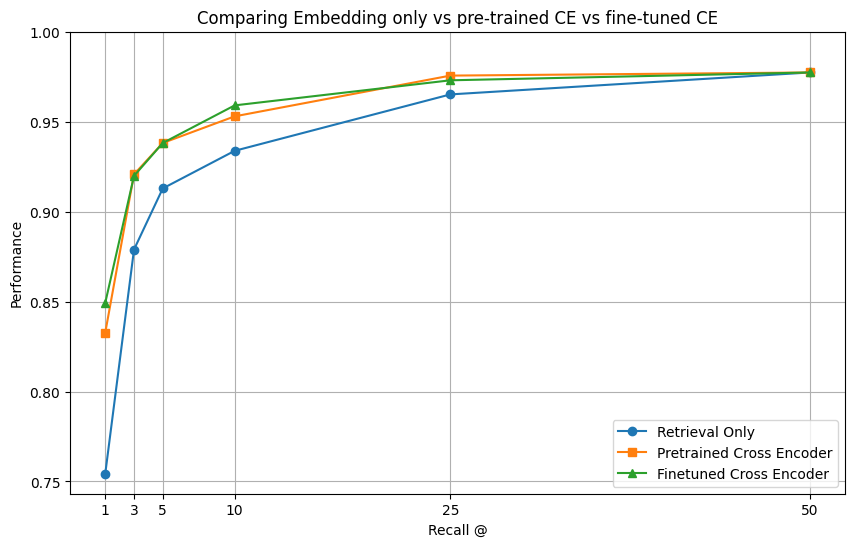

In [ ]:
# do recall @ 1, 3, 5, 10
for k in (1, 3, 5, 10, 25, 50):
    embedding_only_recall = ft_predictions_df[ft_predictions_df['retrieved_correct_position'] < k].shape[0]
    reranked_recall = ft_predictions_df[ft_predictions_df['reranked_correct_position'] < k].shape[0]
    print(k, embedding_only_recall, reranked_recall)

1 866 975
3 1009 1056
5 1048 1077
10 1072 1101
25 1108 1117
50 1122 1122


In [ ]:
ft_predictions_df.shape

(1148, 4)

# OPEN SOURCE ALTERNATIVE TO EMBEDDING

In [ ]:
docs = ["Around 9 Million people live in London", "London is known for its financial district"]
bi_encoder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
doc_emb = bi_encoder.encode(docs, batch_size=32, show_progress_bar=True)

doc_emb.shape#  == ('2, 768')


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(2, 768)

In [ ]:
#Encode query and documents
docs = dataset['test']['context']
doc_emb = bi_encoder.encode(docs, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
from random import sample

query = sample(dataset['test']['question'], 1)[0]
print(query)
final_results = get_results_from_pinecone(query, top_k=3, re_rank_model=finetuned)


Where are some destinations flights from Paris Orly operate to?
Query: Where are some destinations flights from Paris Orly operate to?
Document ID (Hash)		Retrieval Score	CE Score	Text
2cefacc9828ba29e819c9a69e0b7b392	0.69	0.991276	Paris Orly Airport (French: Aéroport de Paris-Orly
bcea700839a1cefc7fbe752fcfbee880	0.24	0.111188	Iran Air Flight 277 was a passenger flight which c
20d2ff7276da85340534dabf110da251	0.24	0.096094	After the Treaty of Paris in 1763, which deprived 


In [ ]:
print(query)
find_most_similar(query, doc_emb, docs)

Where are some destinations flights from Paris Orly operate to?


[('Paris Orly Airport (French: Aéroport de Paris-Orly), commonly referred to as Orly (IATA: ORY, ICAO: LFPO), is an international airport located partially in Orly and partially in Villeneuve-le-Roi, 7 NM (13 km; 8.1 mi) south of Paris, France. It serves as a secondary hub for domestic and overseas territories flights of Air France and as the homebase for Transavia France.  Flights operate to destinations in Europe, the Middle East, Africa, the Caribbean, North America, East Asia and Southeast Asia. Prior to the opening of Charles de Gaulle Airport in March 1974, Orly was the main airport of Paris. Even with the shift of most international traffic to Charles de Gaulle Airport, Orly remains the busiest French airport for domestic traffic and the second busiest French airport overall in passenger traffic, with 33,120,685 passengers in 2018. The airport is operated by Groupe ADP under the brand Paris Aéroport. Since February 2018, the CEO of the airport has been Régis Lacote.',
  0.646585

In [ ]:
def eval_ranking_open_source(query, top_k=3, re_rank_model=None):
    ans = {'retrieved_correct_position': None}
    correct_hash = q_to_hash[query]
    results = find_most_similar(query, doc_emb, docs, k=top_k)
    for idx, (passage, score, doc_idx) in enumerate(results):
        if correct_hash == my_hash(passage):
            ans['retrieved_correct_position'] =  idx
    if re_rank_model is not None:
        ans['reranked_correct_position'] = None
        sentence_combinations = [(query, r[0]) for r in results]

        # Compute the similarity scores for these combinations
        similarity_scores = re_rank_model.predict(sentence_combinations, activation_fct=nn.Sigmoid())

        # Sort the scores in decreasing order
        sim_scores_argsort = list(reversed(np.argsort(similarity_scores)))
        for i, idx in enumerate(sim_scores_argsort):
            r = results[idx]
            if correct_hash and my_hash(r[0]) == correct_hash:
                ans['reranked_correct_position'] = i

    return ans

In [ ]:
eval_ranking_open_source(query, top_k=TOP_K, re_rank_model=finetuned)

{'retrieved_correct_position': 0, 'reranked_correct_position': 0}

In [ ]:
logger.setLevel(logging.CRITICAL)
os_predictions = []

for i, question in tqdm(enumerate(test_sample), total=len(test_sample)):
    os_predictions.append(eval_ranking_open_source(question['question'], top_k=TOP_K, re_rank_model=finetuned))

os_predictions_df = pd.DataFrame(os_predictions)
os_predictions_df.head()

100%|██████████| 1148/1148 [13:31<00:00,  1.42it/s]


,retrieved_correct_position,reranked_correct_position
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,0.0


In [ ]:
raw_accuracy = sum([p['retrieved_correct_position'] == 0 for p in os_predictions])/len(os_predictions)
reranked_accuracy = sum([p['reranked_correct_position'] == 0 for p in os_predictions])/len(os_predictions)

print(f'Accuracy without re-ranking: {raw_accuracy}')
print(f'Accuracy with re-ranking: {reranked_accuracy}')


Accuracy without re-ranking: 0.5017421602787456
Accuracy with re-ranking: 0.6193379790940766


In [ ]:
# do recall @ 1, 3, 5, 10
OPEN_SOURCE_RETRIEVAL = []
OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE = []
for k in (1, 3, 5, 10, 25, 50):
    embedding_only_recall = os_predictions_df[os_predictions_df['retrieved_correct_position'] < k].shape[0]
    reranked_recall = os_predictions_df[os_predictions_df['reranked_correct_position'] < k].shape[0]
    print(k, embedding_only_recall, reranked_recall)
    OPEN_SOURCE_RETRIEVAL.append(embedding_only_recall / os_predictions_df.shape[0])
    OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE.append(reranked_recall / os_predictions_df.shape[0])

1 576 711
3 887 1006
5 948 1055
10 1008 1087
25 1073 1103
50 1107 1107


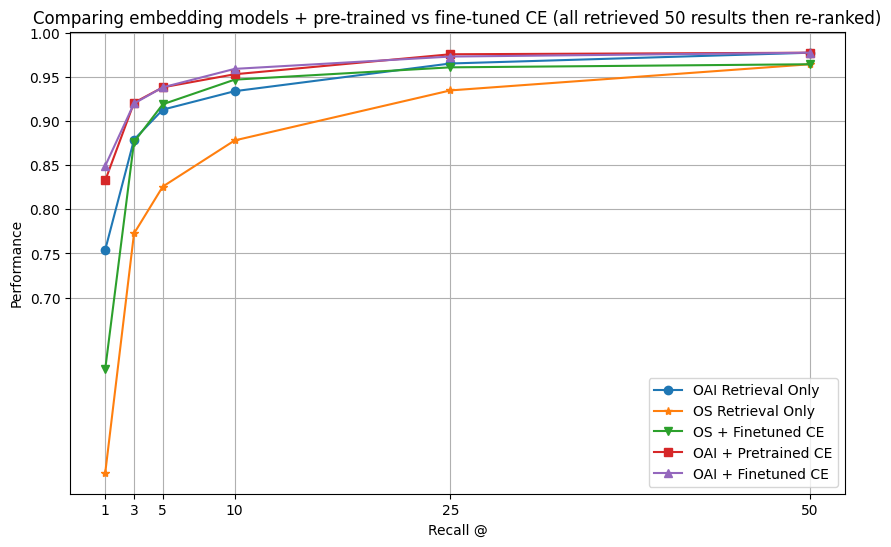

In [ ]:
import matplotlib.pyplot as plt

X = [1, 3, 5, 10, 25, 50]

OPENAI_RETRIEVAL = [866 / predictions_df.shape[0], 1009/ predictions_df.shape[0], 1048/ predictions_df.shape[0], 1072/ predictions_df.shape[0], 1108/ predictions_df.shape[0], 1122/ predictions_df.shape[0]]
# OPEN_SOURCE_RETRIEVAL = [663 / predictions_df.shape[0], 795/ predictions_df.shape[0], 838/ predictions_df.shape[0], 891/ predictions_df.shape[0], 966/ predictions_df.shape[0], 1004/ predictions_df.shape[0]]
OLD_CROSS_ENCODER = [956 / predictions_df.shape[0], 1057/ predictions_df.shape[0], 1077/ predictions_df.shape[0], 1094/ predictions_df.shape[0], 1120/ predictions_df.shape[0], 1122/ predictions_df.shape[0]]
NEW_CROSS_ENCODER = [975 / predictions_df.shape[0], 1056/ predictions_df.shape[0], 1077/ predictions_df.shape[0], 1101/ predictions_df.shape[0], 1117/ predictions_df.shape[0], 1122/ predictions_df.shape[0]]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(X, OPENAI_RETRIEVAL, label='OAI Retrieval Only', marker='o')
plt.plot(X, OPEN_SOURCE_RETRIEVAL, label='OS Retrieval Only', marker='*')
plt.plot(X, OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE, label='OS + Finetuned CE', marker='v')
plt.plot(X, OLD_CROSS_ENCODER, label='OAI + Pretrained CE', marker='s')
plt.plot(X, NEW_CROSS_ENCODER, label='OAI + Finetuned CE', marker='^')

# Adding titles and labels
plt.title('Comparing embedding models + pre-trained vs fine-tuned CE (all retrieved 50 results then re-ranked)')
plt.xlabel('Recall @')
plt.ylabel('Performance')
plt.xticks(X)
plt.yticks([i/100 for i in range(70, 101, 5)])  # Adjusting y-ticks to start from 0.75

# Adding legend
plt.legend()

# Show the plot
plt.grid(True)
# plt.show()

plt.savefig('recall_at_k.png', dpi=1000)

In [ ]:
# show results as a table

results_df = pd.DataFrame({'RECALL @': [1, 3, 5, 10, 25, 50], 'OS_Retrieval_Only': OPEN_SOURCE_RETRIEVAL, 'OS_Retrieval_Plus_Finetuned_CE': OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE   , 'OAI_Retrieval_Only': OPENAI_RETRIEVAL    , 'OAI_Retrieval_Plus_Pretrained_CE': OLD_CROSS_ENCODER, 'OAI_Retrieval_Plus_Finetuned_CE': NEW_CROSS_ENCODER})
results_df

,RECALL @,OS_Retrieval_Only,OS_Retrieval_Plus_Finetuned_CE,OAI_Retrieval_Only,OAI_Retrieval_Plus_Pretrained_CE,OAI_Retrieval_Plus_Finetuned_CE
0,1,0.501742,0.619338,0.754355,0.832753,0.849303
1,3,0.772648,0.876307,0.878920,0.920732,0.919861
2,5,0.825784,0.918990,0.912892,0.938153,0.938153
3,10,0.878049,0.946864,0.933798,0.952962,0.959059
4,25,0.934669,0.960801,0.965157,0.975610,0.972997
5,50,0.964286,0.964286,0.977352,0.977352,0.977352


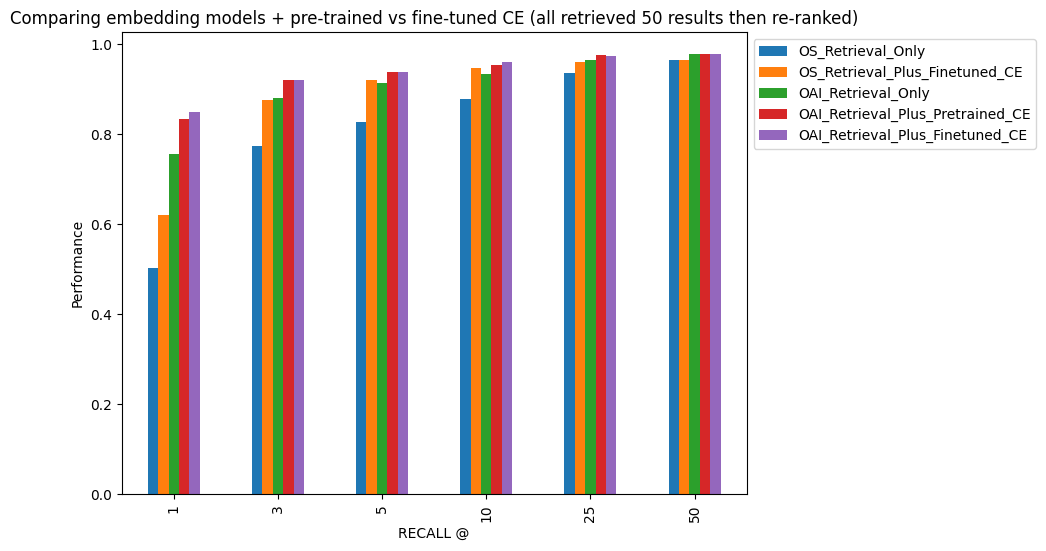

In [ ]:
# Assuming 'results_df' is your DataFrame
# Set 'RECALL @' as the index if it's intended to be used for x-axis labels
results_df.set_index('RECALL @', inplace=True)

# Plot the bar chart
ax = results_df.plot.bar(
    xlabel='RECALL @',
    ylabel='Performance',
    title='Comparing embedding models + pre-trained vs fine-tuned CE (all retrieved 50 results then re-ranked)',
    figsize=(10, 6)
)

# Move the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust subplot parameters to fit the legend outside of the plot
plt.subplots_adjust(right=0.75)

plt.savefig('recall_at_k_bar.png', dpi=1000)


In [ ]:
import pandas as pd

predictions_df = pd.DataFrame({'a': [1] * 1148})

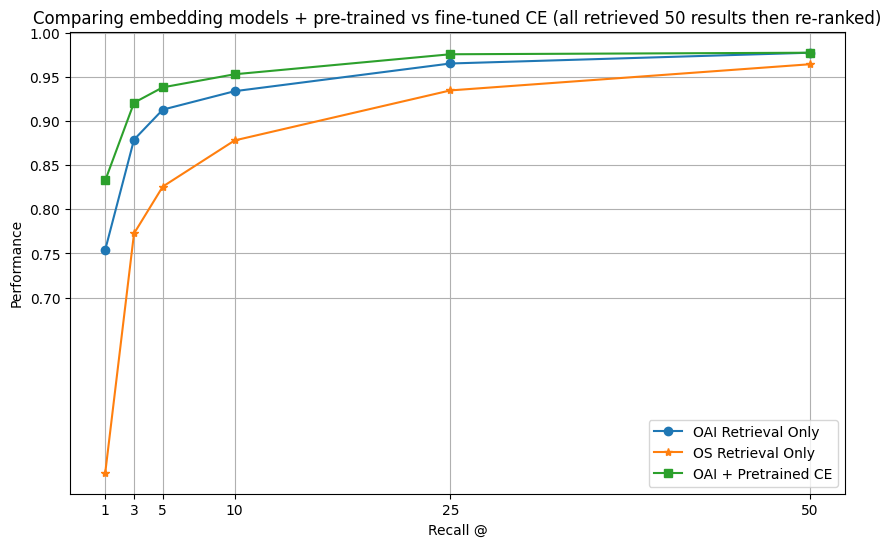

In [ ]:
import matplotlib.pyplot as plt

X = [1, 3, 5, 10, 25, 50]

OPENAI_RETRIEVAL = [866 / predictions_df.shape[0], 1009/ predictions_df.shape[0], 1048/ predictions_df.shape[0], 1072/ predictions_df.shape[0], 1108/ predictions_df.shape[0], 1122/ predictions_df.shape[0]]
OLD_CROSS_ENCODER = [956 / predictions_df.shape[0], 1057/ predictions_df.shape[0], 1077/ predictions_df.shape[0], 1094/ predictions_df.shape[0], 1120/ predictions_df.shape[0], 1122/ predictions_df.shape[0]]

OPEN_SOURCE_RETRIEVAL = [576 / predictions_df.shape[0], 887/ predictions_df.shape[0], 948/ predictions_df.shape[0], 1008/ predictions_df.shape[0], 1073/ predictions_df.shape[0], 1107/ predictions_df.shape[0]]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(X, OPENAI_RETRIEVAL, label='OAI Retrieval Only', marker='o')
plt.plot(X, OPEN_SOURCE_RETRIEVAL, label='OS Retrieval Only', marker='*')
plt.plot(X, OLD_CROSS_ENCODER, label='OAI + Pretrained CE', marker='s')

# Adding titles and labels
plt.title('Comparing embedding models + pre-trained vs fine-tuned CE (all retrieved 50 results then re-ranked)')
plt.xlabel('Recall @')
plt.ylabel('Performance')
plt.xticks(X)
plt.yticks([i/100 for i in range(70, 101, 5)])  # Adjusting y-ticks to start from 0.75

# Adding legend
plt.legend()

# Show the plot
plt.grid(True)
# plt.show()